<a href="https://colab.research.google.com/github/Fu-Pei-Yin/Deep-Generative-Mode/blob/week2/VAE%E5%9C%A8%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97%E4%B8%8A%E7%9A%84%E6%87%89%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.044312
Train Epoch: 1 [1280/60000 (2%)]	Loss: 299.170044
Train Epoch: 1 [2560/60000 (4%)]	Loss: 236.659531
Train Epoch: 1 [3840/60000 (6%)]	Loss: 226.714142
Train Epoch: 1 [5120/60000 (9%)]	Loss: 209.140900
Train Epoch: 1 [6400/60000 (11%)]	Loss: 213.655930
Train Epoch: 1 [7680/60000 (13%)]	Loss: 205.193497
Train Epoch: 1 [8960/60000 (15%)]	Loss: 201.648880
Train Epoch: 1 [10240/60000 (17%)]	Loss: 207.146759
Train Epoch: 1 [11520/60000 (19%)]	Loss: 197.486618
Train Epoch: 1 [12800/60000 (21%)]	Loss: 181.042755
Train Epoch: 1 [14080/60000 (23%)]	Loss: 194.835831
Train Epoch: 1 [15360/60000 (26%)]	Loss: 186.933975
Train Epoch: 1 [16640/60000 (28%)]	Loss: 182.255829
Train Epoch: 1 [17920/60000 (30%)]	Loss: 176.380432
Train Epoch: 1 [19200/60000 (32%)]	Loss: 175.244736
Train Epoch: 1 [20480/60000 (34%)]	Loss: 168.506119
Train Epoch: 1 [21760/60000 (36%)]	Loss: 171.933456
Train Epoch: 1 [23040/60000 (38%)]	Loss: 166.919693
Train Epoch: 1 [24320/60000 

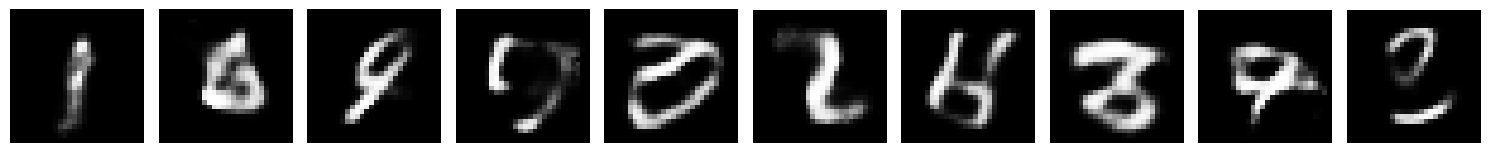

VAE 訓練完成！已生成10張隨機影像並儲存至 results/vae_generated_10.png


In [5]:
# Cell 1: import & 設定
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt

# Cell 2: 參數設定 & 輔助函式
batch_size = 128
learning_rate = 1e-3
num_epochs = 30  # 符合檔案建議的 30 epochs
z_dim = 100  # 符合檔案要求的 z 維度 100
log_interval = 10

# 設定隨機種子
torch.manual_seed(42)

if not os.path.exists('results'):
    os.makedirs('results')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cell 3: 定義 VAE 模型
class VAE(nn.Module):
    def __init__(self, z_dim=100):
        super(VAE, self).__init__()
        # encoder layers
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, z_dim)  # μ
        self.fc22 = nn.Linear(400, z_dim)  # logσ^2

        # decoder layers
        self.fc3 = nn.Linear(z_dim, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Cell 4: 損失函式（重構誤差 + KL 散度）
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Cell 5: 載入資料集
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False)

# Cell 6: model、optimizer 設定
model = VAE(z_dim=z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Cell 7: 訓練迴圈
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

    # 每10個epoch儲存一次重建影像
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            sample = torch.randn(64, z_dim).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                      'results/sample_' + str(epoch) + '.png')

# Cell 8: 在測試集上評估
model.eval()
test_loss = 0
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        recon, mu, logvar = model(data)
        test_loss += loss_function(recon, data, mu, logvar).item()

test_loss /= len(test_loader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))

# Cell 9: 隨機生成10張影像（符合檔案要求）
model.eval()
with torch.no_grad():
    # 生成10個隨機潛在向量
    sample_z = torch.randn(10, z_dim).to(device)
    generated_imgs = model.decode(sample_z).cpu()

    # 儲存生成的10張影像
    save_image(generated_imgs.view(10, 1, 28, 28), 'results/vae_generated_10.png')

    # 顯示生成的影像
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(generated_imgs[i].view(28, 28), cmap='gray')
        axes[i].axis('off')
    plt.tight_layout()
    plt.savefig('results/vae_final_10_images.png')
    plt.show()

print("VAE 訓練完成！已生成10張隨機影像並儲存至 results/vae_generated_10.png")